In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

seed = 42
np.set_printoptions(precision=3, suppress=True)

In [33]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin", "name"]

raw_dataset = pd.read_csv(
        url,
        delim_whitespace=True,
        na_values='?',
        header=None,
        names=columns)

raw_dataset.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [37]:
dataset_X = raw_dataset.drop(['mpg', 'name'], axis=1)
dataset_Y = raw_dataset['mpg']

In [38]:
dataset_X.isnull().any()

dataset_X.fillna(dataset_X.mean(numeric_only=True), inplace=True)
#dataset_X.isnull().any()

In [39]:
training_mean = dataset_X.mean()
training_std = dataset_X.std()
dataset_X = (dataset_X - training_mean) / training_std

# trainingY_mean = dataset_Y.mean()
# trainingY_std = dataset_Y.std()
# dataset_Y = (dataset_Y - trainingY_mean) / trainingY_std

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(dataset_X, dataset_Y, test_size=0.245, random_state=seed)
len(X_train), len(X_val)

(300, 98)

In [41]:
def get_metrics(pred, gt, unnormalized=False):
    
    if unnormalized:
        pred = pred * trainingY_std + trainingY_mean
        gt = gt * trainingY_std + trainingY_mean
    
    error = pred - gt
    
    MAE = sum(abs(pred - gt)) / len(gt)
    MSE = sum((pred - gt) ** 2) / len(gt)
    
    return MAE, MSE

### Linear regression

In [42]:
import numpy as np
import copy

# Пример: X shape (N, D), y shape (N,)
X = copy.deepcopy(X_train)
y = copy.deepcopy(Y_train)

# 1. Добавим столбец единиц (смещение)
N = X.shape[0]
X_ext = np.hstack([np.ones((N, 1)), X])  # shape (N, D+1)

# 2. Считаем веса
w_ext = np.linalg.inv(X_ext.T @ X_ext) @ X_ext.T @ y     # (D+1,)

# 3. Предсказания
y_pred = X_ext @ w_ext

print('Train metrics:')
mae, mse = get_metrics(y_pred, Y_train)
print(f'MAE: {mae:.2f}; MSE: {mse:.2f}')

print('Val metrics:')

# inference
X = copy.deepcopy(X_val)

N = X.shape[0]
X_ext = np.hstack([np.ones((N, 1)), X])
y_pred = X_ext @ w_ext

mae, mse = get_metrics(y_pred, Y_val)
print(f'MAE: {mae:.2f}; MSE: {mse:.2f}')

Train metrics:
MAE: 2.58; MSE: 11.60
Val metrics:
MAE: 2.35; MSE: 9.13


In [43]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, Y_train)

pred = model.predict(X_val)
get_metrics(pred, Y_val)

(2.3454763093950644, 9.12712569116044)

### Catboost

In [44]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function='RMSE', random_seed=seed, verbose=0, early_stopping_rounds=30)
model.fit(X_train, Y_train)

print('Train metrics:')
pred = model.predict(X_train)
mae, mse = get_metrics(pred, Y_train)
print(f'MAE: {mae:.2f}; MSE: {mse:.2f}')

print('Val metrics:')
pred = model.predict(X_val)
mae, mse = get_metrics(pred, Y_val)
print(f'MAE: {mae:.2f}; MSE: {mse:.2f}')

Train metrics:
MAE: 0.52; MSE: 0.43
Val metrics:
MAE: 1.57; MSE: 4.52


### MLP

In [45]:
inp_size = 7
mid_size = 32
out_shape = 1

limit = np.sqrt(6 / (inp_size + mid_size))
W1 = np.random.uniform(-limit, limit, size=(inp_size, mid_size)).astype(np.float32)
b1 = np.random.uniform(0, 1, size=(mid_size)).astype(np.float32) * 0.1

limit = np.sqrt(6 / (mid_size + out_shape))
W2 = np.random.uniform(-limit, limit, size=(mid_size, out_shape)).astype(np.float32)
b2 = np.random.uniform(0, 1, size=(out_shape)).astype(np.float32) * 0.1

W1.shape, b1.shape, W2.shape, b2.shape

((7, 32), (32,), (32, 1), (1,))

In [46]:
parameters = [W1, b1, W2, b2]
sum(p.size for p in parameters)

289

In [47]:
# # utility function we will use later when comparing manual gradients to PyTorch gradients
# def cmp(s, dt, t):
#     ex = torch.all(dt == t.grad).item()
#     app = torch.allclose(dt, t.grad)
#     maxdiff = (dt - t.grad).abs().max().item()
#     print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [48]:
import math

_batch_size = 32
_lr = 5e-2

train_loss = []
val_loss = []
cur_eph = 0

In [49]:
for e in range(cur_eph, cur_eph + 30):
    print(f"{'-' * 10} Epoch : {e} {'-' * 10}")
    cur_eph += 1
    
    losses = []
    MSE = []
    MAE = []
    
    for i in range(int(len(X_train) / _batch_size) + 1):
        batch_idx = np.arange(_batch_size * i, min(_batch_size * (i + 1), len(X_train)))
        
        batch = X_train.values[batch_idx]
        labels = np.expand_dims(Y_train.values[batch_idx], 1) # convert shape (32) to (32, 1)
        
        Z1 = batch @ W1 + b1
        A1 = (math.e**Z1 - math.e**(-Z1)) / (math.e**Z1 + math.e**(-Z1)) # tanh(Z1)
        out = (A1 @ W2 + b2)

        loss = ((out - labels)**2).mean()
                
        delta = 2.0 * (out - labels) / len(labels)
        
        dW2 = A1.T @ delta
        db2 = delta.sum(axis=0)
        
        dA1 = delta @ W2.T
        dZ1 = dA1 * (1 - A1**2)
        
        dW1 = batch.T @ dZ1
        db1 = dZ1.sum(axis=0)
        
        # checker
        #cmp('w2', dW2, W2); cmp('b2', db2, b2); cmp('w1', dW1, W1); cmp('b1', db1, b1)
        #parameters = [W1, b1, W2, b2]
        
        grads = [dW1, db1, dW2, db2]
        
        for param, grad in zip(parameters, grads):
            #param.data += -_lr * param.grad
            param += -_lr * grad

        mae, mse = get_metrics(out, labels)
        losses.append(loss)
        MAE.append(mae[0])
        MSE.append(mse[0])
        
    avgLoss = sum(losses) / len(losses)
    avgMAE = sum(MAE) / len(MAE)
    avgMSE = sum(MSE) / len(MSE)
    train_loss.append(avgLoss)
    print(f'train loss: {avgLoss:.4f}; mae: {avgMAE:.4f}; mse: {avgMSE:.4f}')
    
    losses = []
    MSE = []
    MAE = []
    
    for i in range(int(len(X_val) / _batch_size) + 1):
        batch_idx = np.arange(_batch_size * i, min(_batch_size * (i + 1), len(X_val)))
        
        batch = X_val.values[batch_idx]
        labels = np.expand_dims(Y_val.values[batch_idx], 1) # convert shape (32) to (32, 1)
        
        Z1 = batch @ W1 + b1
        A1 = (math.e**Z1 - math.e**(-Z1)) / (math.e**Z1 + math.e**(-Z1)) # tanh(Z1)
        out = (A1 @ W2 + b2)
        
        loss = ((out - labels)**2).mean()
        losses.append(loss)
        
        mae, mse = get_metrics(out, labels)
        MAE.append(mae[0])
        MSE.append(mse[0])
        
    avgLoss = sum(losses) / len(losses)
    avgMAE = sum(MAE) / len(MAE)
    avgMSE = sum(MSE) / len(MSE)
    val_loss.append(avgLoss)
    print(f'val loss: {avgLoss:.4f}; mae: {avgMAE:.4f}; mse: {avgMSE:.4f}')

---------- Epoch : 0 ----------
train loss: 205.6700; mae: 10.6867; mse: 205.6700
val loss: 13.7206; mae: 2.6421; mse: 13.7206
---------- Epoch : 1 ----------
train loss: 22.7255; mae: 3.6184; mse: 22.7255
val loss: 17.7098; mae: 3.2336; mse: 17.7098
---------- Epoch : 2 ----------
train loss: 26.3732; mae: 4.0250; mse: 26.3732
val loss: 12.4062; mae: 2.6005; mse: 12.4062
---------- Epoch : 3 ----------
train loss: 16.4572; mae: 3.0460; mse: 16.4572
val loss: 9.5989; mae: 2.4219; mse: 9.5989
---------- Epoch : 4 ----------
train loss: 13.0197; mae: 2.7103; mse: 13.0197
val loss: 8.6831; mae: 2.3476; mse: 8.6831
---------- Epoch : 5 ----------
train loss: 11.5028; mae: 2.5503; mse: 11.5028
val loss: 7.9834; mae: 2.2663; mse: 7.9834
---------- Epoch : 6 ----------
train loss: 10.3726; mae: 2.4189; mse: 10.3726
val loss: 7.4644; mae: 2.1987; mse: 7.4644
---------- Epoch : 7 ----------
train loss: 9.5691; mae: 2.3252; mse: 9.5691
val loss: 7.1111; mae: 2.1555; mse: 7.1111
---------- Epoch 

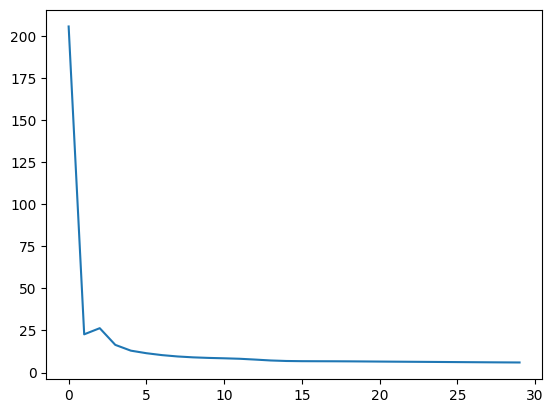

In [50]:
plt.plot(train_loss)

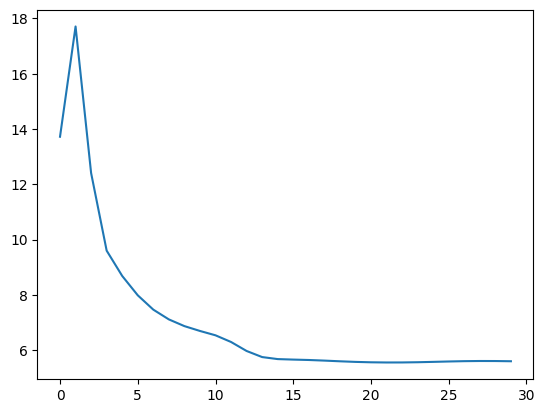

In [51]:
plt.plot(val_loss)

In [68]:
# inference 

idx = 73

sample = raw_dataset.iloc[idx]
sample

mpg                                         13.0
cylinders                                      8
displacement                               307.0
horsepower                                 130.0
weight                                    4098.0
acceleration                                14.0
year                                          72
origin                                         1
name            chevrolet chevelle concours (sw)
Name: 73, dtype: object

In [69]:
car_info = sample[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']]
car_mpg = sample['mpg']

car_info = (car_info - training_mean) / training_std

In [70]:
Z1 = car_info @ W1 + b1
out = (math.e**Z1 - math.e**(-Z1)) / (math.e**Z1 + math.e**(-Z1)) # tahn
out = (out @ W2 + b2)[0]
#out = out * trainingY_std + trainingY_mean

print(f'pred: {out:.2f}, gt: {car_mpg}, error: {abs(car_mpg - out):.2f}')

pred: 11.87, gt: 13.0, error: 1.13
